## **Trading Strategy**

Performed **sample runs** on the developed **quintile-based long-short trading strategy** using computed **realized and implied H values** for a selected investment period (**2010–2023**) and tickers.  

🔹 **Note:** Implied H values still need to be computed for the **entire investment universe**.

#### **For the Final Submission:**
We aim to refine and enhance the strategy by:
- 📈 **Incorporating additional features** to improve signal robustness.
  - For example:
    - Construct **long-only portfolios** across all quintiles.  
    - Explore **different long-short combinations** to optimize strategy performance. 
- 💰 **Accounting for trading costs** to reflect real market conditions.  
- 📊 **Implementing risk controls** (e.g., liquidity constraints, factor exposure adjustments).  
- 🏆 **Conducting robust and detailed backtesting** to evaluate performance, risk-adjusted returns, and strategy viability under realistic conditions, alpha generation.

#### **Objective**
The goal is to create a **realistic, well-tested, and effective trading strategy** based on volatility roughness.

In [506]:
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy as sp
from scipy.stats import zscore
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from datetime import timedelta as td
import statsmodels.api as sm
import random
from functools import reduce
from scipy.stats import skew, kurtosis

### **H Value Data**

In [507]:
realised_h_df = pd.read_csv(r'.//Realized_H/Realized_H_Data.csv')
realised_h_df.rename(columns={'Realized_H':'H_value'}, inplace=True)
realised_h_df

,date,H_value,ticker,price
0,2010-01-29,0.137720,AAPL,192.063
1,2010-02-26,0.130794,AAPL,204.620
2,2010-03-31,0.071049,AAPL,235.000
3,2010-04-30,0.137683,AAPL,261.090
4,2010-05-28,5.734701,AAPL,256.880
...,...,...,...,...
15457,2023-04-28,0.023559,XOM,118.340
15458,2023-05-31,0.016606,XOM,102.180
15459,2023-06-30,0.052514,XOM,107.250
15460,2023-07-31,0.068541,XOM,107.240


In [508]:
implied_h_df = pd.read_csv(r'./H_values_output.csv')
implied_h_df.rename(columns={'close': 'price'}, inplace=True)
implied_h_df

,ticker,date,H_value,price,year,month
0,AAPL,2010-01-04,0.484942,214.00999,2010,1
1,AAPL,2010-01-05,0.636062,214.38000,2010,1
2,AAPL,2010-01-06,0.655399,210.97000,2010,1
3,AAPL,2010-01-07,0.607898,210.58000,2010,1
4,AAPL,2010-01-08,0.504162,211.98000,2010,1
...,...,...,...,...,...,...
307298,XOM,2023-08-25,0.191836,108.25000,2023,8
307299,XOM,2023-08-28,0.026036,109.16000,2023,8
307300,XOM,2023-08-29,0.156011,109.81000,2023,8
307301,XOM,2023-08-30,0.129502,110.88000,2023,8


### **Downloading Daily blended LIBOR/SOFR Data**

In [509]:
sofr_data = pd.read_csv(r"/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Project/buy-rough-sell-smooth/FINM33150_Interp_LIBOR_SOFR_to_2025.tab", sep="\t")
# Rename the first column to "date"
sofr_data.rename(columns={sofr_data.columns[0]: "date", sofr_data.columns[1]:"sofr"}, inplace=True)

import pandas as pd

# Example: sofr_data has columns ["date", "sofr"] with daily data
# 1) Convert "date" column to datetime
sofr_data["date"] = pd.to_datetime(sofr_data["date"])

# 2) Sort by date to ensure chronological order
sofr_data.sort_values("date", inplace=True)

# 3) Set "date" as the index (needed for rolling)
sofr_data.set_index("date", inplace=True)

# 4) Forward-fill any missing SOFR values
sofr_data["sofr"] = sofr_data["sofr"].ffill()

# 5) Compute the 3-month (90-day) rolling average
#    If you want at least some average even when fewer than 90 days of data are available, use min_periods=1
sofr_data["sofr_3M_Rolling_Avg"] = sofr_data["sofr"].rolling(window=90, min_periods=1).mean()

# 6) (Optional) Reset the index so "date" is a column again
sofr_data.reset_index(inplace=True)

# Display the result
print(sofr_data.tail())



            date  sofr  sofr_3M_Rolling_Avg
10185 2025-01-16  4.29             4.671556
10186 2025-01-17  4.29             4.660000
10187 2025-01-20  4.29             4.647889
10188 2025-01-21  4.29             4.635778
10189 2025-01-22  4.30             4.624333


### Downloading Monthly Ticker Values

In [510]:
monthly_prices = pd.read_csv(r"/Users/pr/Downloads/UChicago MSFM/Winter Quarter/QTS/Project/buy-rough-sell-smooth/monthly_ticker_prices.csv")
monthly_prices

,PERMNO,date,TICKER,PRC
0,10104,2010-01-29,ORCL,23.06000
1,10104,2010-02-26,ORCL,24.65000
2,10104,2010-03-31,ORCL,25.71000
3,10104,2010-04-30,ORCL,25.86750
4,10104,2010-05-28,ORCL,22.57000
...,...,...,...,...
17752,93436,2023-04-28,TSLA,164.31000
17753,93436,2023-05-31,TSLA,203.92999
17754,93436,2023-06-30,TSLA,261.76999
17755,93436,2023-07-31,TSLA,267.42999


### **Trading Strategy Implementation**

#### **Ranking Methodology: Quintile Ranking of H_value**

The ranking process assigns each ticker a rank from 1 to 5 within each month based on its roughness using the Hurst Index (H) value:

1. **Within-Month Sorting:**  
   Tickers are ordered by their H value on each month.  
   - The ticker with the highest H value is placed at the top.
   - The ticker with the lowest H value is placed at the bottom.

2. **Quintile Assignment:**  
   The ordered list is then divided into five equally sized groups (quintiles).  
   - **Rank 1:** Tickers with the highest H values.
   - **Rank 5:** Tickers with the lowest H values.
   - Intermediate ranks indicate middle groupings.

#### **Ranking Interpretation**
Within each month, every ticker receives an integer rank from **1** to **5**:
- **Rank 1:** Represents the most favorable condition for short positions.
- **Rank 5:** Represents the most favorable condition for long positions.
- Tickers with intermediate ranks remain neutral.

---

#### **Signal Generation**

Based on the quintile rankings:
- **Short Signal:** Issued to tickers with a rank equal to the predefined short threshold (Rank 1).
- **Long Signal:** Issued to tickers with a rank equal to the predefined long threshold (Rank 5).
- **Neutral:** Tickers with intermediate ranks receive no position.

By default, the strategy assumes trading 1 share per asset, though this can be adjusted as needed.

---

#### **Trading Strategy**

1. **Rebalancing:**  
   The portfolio is rebalanced monthly. Signals are generated at month-end and applied on the following trading day.

2. **Profit/Loss Computation:**  
   - **Price Change:** The difference between the current and previous price is calculated for each ticker.
   - **PnL Calculation:** The trading signal is multiplied by the price change to compute the raw profit or loss.
   - **Short Borrow Cost:** For short positions, a monthly borrowing cost is subtracted.
   - **Position Notional:** Exposure per ticker is computed as the product of the previous period's price and the absolute value of the signal.

3. **Return Calculation:**  
   - **Monthly Return:** Calculated as the total PnL divided by the total notional exposure (capital at risk) across all positions.
   - **Cumulative Return:** Determined by compounding the monthly returns over time.

4. **Capital Scaling:**  
   The strategy evaluates performance on a consistent capital basis by normalizing returns with the aggregated notional exposure.

---

This methodology ensures that the trading strategy dynamically ranks tickers each month, generates clear long/short signals, and computes performance in a normalized, capital-adjusted manner.


In [511]:
# Modify the function to rank h_vals into groups per date
def rank_H_quintiles(df, groups=5):
    # Ensure date column is in datetime format
    monthly = df.copy()
    monthly["date"] = pd.to_datetime(monthly["date"])
    
    # Sort values by date and h_val
    monthly = monthly.sort_values(["date", "H_value"])
    
    # Assign quintile ranks (1 to 5) based on h_val per date
    monthly["h_rank"] = (
    monthly.groupby("date")["H_value"]
    .transform(lambda x: pd.qcut(-x, q=groups, labels=False, duplicates='drop') + 1)
    )
    
    # Sort final result by ticker & date
    monthly = monthly.sort_values(["ticker", "date"]).reset_index(drop=True)
    
    return monthly

In [512]:
def generate_signal(rank_val, long=5, short=1, strat="long-short"):
    """
    Example signal generator for demonstration.
    Adjust as needed for your actual logic.
    """
    if strat == "long":
        return 1 if rank_val == long else 0
    elif strat == "short":
        return -1 if rank_val == short else 0
    else:  # long-short
        if rank_val == long:
            return 1 
        elif rank_val == short:
            return -1
        else:
            return 0

In [513]:
def trading_strategy(
    df,                    # DataFrame: at least ['date','ticker','price','h_rank','H_value']
    monthly_prices,        # DataFrame: columns ['PERMNO','date','TICKER','PRC'] (the canonical set of monthly points)
    long=5,
    short=1,
    transaction_cost=0.00001,     # fraction of allocated capital as transaction cost
    initial_equity=1_000_000,
    leverage=5,
    strat="long/short",
    weighted_allocation=True      # If True, weight allocation by H_value; if False, use equal weighting.
):
    """
    Implements a monthly rebalanced long/short strategy with the following rules:
      Scenario 1: Had an open position → close it (pay closing cost) → if data is available, open new position (pay opening cost).
      Scenario 2: Had an open position → close it (pay closing cost) → if data is missing (NaN), do not open a new position.
      Scenario 3: No position open → if new data is available, open position (pay opening cost).
      Scenario 4: No position open → if data is missing, remain with no position (no cost).

    PnL is realized from closing an old position and new positions are opened based solely on the current month's signal.
    'PRC' is used as fallback if 'price' is missing.
    
    The allocation for new positions can be computed in one of two ways:
      - If weighted_allocation is True: for longs, tickers with lower H_value get higher weight;
        for shorts, tickers with higher H_value get higher weight.
      - Otherwise, allocation is equal (long_exposure/n_long, etc.) as before.

    Returns:
      merged  -> The merged DataFrame with signals and intermediate columns.
      perf_df -> Monthly performance tracking DataFrame with:
                 date, realized_pnl, portfolio_val, monthly_return, cum_return,
                 position_open, position_close, no_position.
    """
    import pandas as pd
    import numpy as np

    ######################################
    # 1) Prepare & Merge Data
    ######################################
    df_copy = df.copy()
    df_copy["date"] = pd.to_datetime(df_copy["date"])
    df_copy.sort_values(["ticker", "date"], inplace=True)

    # Generate signals (if not already present)
    df_copy["h_signal"] = df_copy["h_rank"].apply(lambda r: generate_signal(r, long, short, strat))

    # Convert monthly_prices to datetime and sort
    mp_copy = monthly_prices.copy()
    mp_copy["date"] = pd.to_datetime(mp_copy["date"])
    mp_copy.sort_values(["TICKER", "date"], inplace=True)

    # Merge df_copy onto mp_copy by matching date and TICKER.
    merged = pd.merge(
        mp_copy, 
        df_copy[["date", "ticker", "price", "H_value", "h_rank", "h_signal"]],
        left_on=["date", "TICKER"],
        right_on=["date", "ticker"],
        how="left"
    )
    merged.drop(columns=["ticker"], inplace=True)
    merged.sort_values(["TICKER", "date"], inplace=True, ignore_index=True)

    ######################################
    # 2) Iterate Month-by-Month
    ######################################
    prev_equity = initial_equity

    # Dictionary to track open positions from the prior month.
    # open_positions[ticker] = {"signal": ..., "entry_price": ..., "allocation": ...}
    open_positions = {}

    monthly_pnl_records = []

    all_dates = merged["date"].unique()
    for dt in all_dates:
        current_slice = merged[merged["date"] == dt].copy()

        # Flags to track events this month.
        position_closed = False
        position_opened = False

        # -----------------------------
        # 2A) Close out prior positions
        # -----------------------------
        realized_pnl = 0.0
        if open_positions:
            position_closed = True
            for tk, pos in list(open_positions.items()):
                old_signal = pos["signal"]
                old_price = pos["entry_price"]
                allocation = pos["allocation"]

                # Find the row for this TICKER in the current_slice.
                row_ticker = current_slice[current_slice["TICKER"] == tk]
                if not row_ticker.empty:
                    # Prefer 'price' and fallback to 'PRC'
                    close_price = row_ticker["price"].iloc[0]
                    if pd.isna(close_price):
                        close_price = row_ticker["PRC"].iloc[0]
                    if pd.notna(close_price):
                        ret = (close_price - old_price) / old_price
                        if old_signal == -1:
                            ret = -ret
                        pos_pnl = allocation * ret
                        pos_pnl -= allocation * transaction_cost  # Closing cost
                        realized_pnl += pos_pnl
                    else:
                        realized_pnl -= allocation * transaction_cost
                else:
                    realized_pnl -= allocation * transaction_cost

                # Remove the closed position.
                open_positions.pop(tk)
        
        if pd.isna(realized_pnl):
            realized_pnl = 0.0

        portfolio_val_after_close = prev_equity + realized_pnl

        # -----------------------------
        # 2B) Open new positions this month
        # -----------------------------
        valid_slice = current_slice.dropna(subset=["h_signal"])

        # Split into long and short slices.
        long_slice = valid_slice[valid_slice["h_signal"] == 1].copy()
        short_slice = valid_slice[valid_slice["h_signal"] == -1].copy()
        n_long = len(long_slice)
        n_short = len(short_slice)

        total_exposure = portfolio_val_after_close
        long_exposure = total_exposure / 2 if n_long > 0 else 0
        short_exposure = total_exposure / 2 if n_short > 0 else 0

        if weighted_allocation:
            # For long positions: weight = max(H_value) - H_value.
            if n_long > 0:
                long_slice["weight"] = long_slice["H_value"].max() - long_slice["H_value"]
                weight_sum = long_slice["weight"].sum()
                if weight_sum != 0:
                    long_slice["weight"] = long_slice["weight"] / weight_sum
                else:
                    long_slice["weight"] = 1.0 / n_long
            # For short positions: weight = H_value - min(H_value).
            if n_short > 0:
                short_slice["weight"] = short_slice["H_value"] - short_slice["H_value"].min()
                weight_sum = short_slice["weight"].sum()
                if weight_sum != 0:
                    short_slice["weight"] = short_slice["weight"] / weight_sum
                else:
                    short_slice["weight"] = 1.0 / n_short
        else:
            # Equal weighting.
            if n_long > 0:
                long_slice["weight"] = 1.0 / n_long
            if n_short > 0:
                short_slice["weight"] = 1.0 / n_short

        # Open positions for longs.
        if n_long > 0:
            for idx, row in long_slice.iterrows():
                tk = row["TICKER"]
                open_price = row["price"]
                if pd.isna(open_price):
                    continue
                allocation = long_exposure * row["weight"]
                open_cost = allocation * transaction_cost
                realized_pnl -= open_cost
                open_positions[tk] = {"signal": 1, "entry_price": open_price, "allocation": allocation}
            position_opened = True

        # Open positions for shorts.
        if n_short > 0:
            for idx, row in short_slice.iterrows():
                tk = row["TICKER"]
                open_price = row["price"]
                if pd.isna(open_price):
                    continue
                allocation = short_exposure * row["weight"]
                open_cost = allocation * transaction_cost
                realized_pnl -= open_cost
                open_positions[tk] = {"signal": -1, "entry_price": open_price, "allocation": allocation}
            position_opened = True

        # -----------------------------
        # 2C) Record performance for this month.
        # -----------------------------
        new_equity = prev_equity + realized_pnl
        monthly_ret = realized_pnl / prev_equity if prev_equity != 0 else 0

        # Determine if no new position was taken and no closing occurred.
        no_position = not (position_closed or position_opened)

        monthly_pnl_records.append({
            "date": dt,
            "realized_pnl": realized_pnl,
            "portfolio_val": new_equity,
            "monthly_return": monthly_ret,
            "position_open": position_opened,
            "position_close": position_closed,
            "no_position": no_position
        })

        prev_equity = new_equity

    perf_df = pd.DataFrame(monthly_pnl_records).sort_values("date")
    perf_df["realized_pnl"] = perf_df["realized_pnl"].fillna(0)
    perf_df["cum_return"] = (perf_df["portfolio_val"] - initial_equity) / initial_equity

    return merged, perf_df


In [514]:
realised_h_rank_df = rank_H_quintiles(realised_h_df)
realised_h_positions, realised_h_strat_returns = trading_strategy(
    realised_h_rank_df,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)
realised_h_strat_returns

,date,realized_pnl,portfolio_val,monthly_return,position_open,position_close,no_position,cum_return
0,2010-01-29,-10.000000,999990.000000,-0.000010,True,False,False,-0.000010
1,2010-02-26,-8430.180986,991559.819014,-0.008430,True,True,False,-0.008440
2,2010-03-31,-6165.465558,985394.353456,-0.006218,True,True,False,-0.014606
3,2010-04-30,-71336.787279,914057.566177,-0.072394,True,True,False,-0.085942
4,2010-05-28,-3663.236136,910394.330041,-0.004008,True,True,False,-0.089606
...,...,...,...,...,...,...,...,...
159,2023-04-28,5129.242075,654607.395831,0.007897,True,True,False,-0.345393
160,2023-05-31,8762.652551,663370.048382,0.013386,True,True,False,-0.336630
161,2023-06-30,-12980.277975,650389.770407,-0.019567,True,True,False,-0.349610
162,2023-07-31,-3434.864867,646954.905540,-0.005281,True,True,False,-0.353045


In [515]:
implied_h_df['date'] = pd.to_datetime(implied_h_df['date'])
monthly_implied_h_df = (
    implied_h_df
    .groupby(['ticker', pd.Grouper(key='date', freq='M')])  # Resample each ticker by month-end
    .agg({
        'price': 'last',  # Last price of the month
        'H_value': 'mean'  # Mean H-value for the month
    })
    .reset_index()
)

/var/folders/ym/jy9bfkc1719_43grtmk04syw0000gn/T/ipykernel_38815/1540211826.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .groupby(['ticker', pd.Grouper(key='date', freq='M')])  # Resample each ticker by month-end


In [516]:
monthly_implied_h_df

,ticker,date,price,H_value
0,AAPL,2010-01-31,192.063,0.403449
1,AAPL,2010-02-28,204.620,0.175181
2,AAPL,2010-03-31,235.000,0.274820
3,AAPL,2010-04-30,261.090,0.421337
4,AAPL,2010-05-31,256.880,0.024329
...,...,...,...,...
14666,XOM,2023-04-30,118.340,0.161154
14667,XOM,2023-05-31,102.180,0.134262
14668,XOM,2023-06-30,107.250,0.260377
14669,XOM,2023-07-31,107.240,0.274694


In [517]:
implied_h_rank_df = rank_H_quintiles(monthly_implied_h_df)
implied_h_positions, implied_h_strat_returns = trading_strategy(
    implied_h_rank_df,
    monthly_prices,
    long=5,
    short=1,
    strat = "long-short",
    weighted_allocation=True
)
implied_h_strat_returns

,date,realized_pnl,portfolio_val,monthly_return,position_open,position_close,no_position,cum_return
0,2010-01-29,0.000000,1.000000e+06,0.000000,False,False,True,0.000000
1,2010-02-26,0.000000,1.000000e+06,0.000000,False,False,True,0.000000
2,2010-03-31,-10.000000,9.999900e+05,-0.000010,True,False,False,-0.000010
3,2010-04-30,-13391.824008,9.865982e+05,-0.013392,True,True,False,-0.013402
4,2010-05-28,-20937.044519,9.656611e+05,-0.021221,False,True,False,-0.034339
...,...,...,...,...,...,...,...,...
159,2023-04-28,21251.663266,1.759209e+06,0.012228,False,True,False,0.759209
160,2023-05-31,-17.592086,1.759191e+06,-0.000010,True,False,False,0.759191
161,2023-06-30,-20001.669187,1.739189e+06,-0.011370,True,True,False,0.739189
162,2023-07-31,-17858.929989,1.721330e+06,-0.010269,True,True,False,0.721330


### **Backtesting / Analysis**

In [518]:
def plot_monthly_pnl(pnl_df: pd.DataFrame, window: int = 4) -> pd.DataFrame:
    """
    Plots the monthly PnL time-series with a moving average line, cumulative PnL, and rolling volatility.
    
    Parameters:
      pnl_df: DataFrame with a 'date' column and columns 'pnl' and 'cum_pnl'.
      window: The window (in months) over which to compute the moving average and volatility (default is 3 months).
      
    Returns:
      summary_df: A DataFrame with summary statistics for pnl and cum_pnl.
    """
    # Create a copy and ensure 'date' is datetime and set as index.
    df = pnl_df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)
    
    # Compute the moving average for pnl.
    df['Moving_Avg'] = df['monthly_return'].rolling(window=window).mean()
    
    # Compute rolling volatility (standard deviation) for pnl.
    df['Rolling_Vol'] = df['monthly_return'].rolling(window=window).std()
    # Annualize the volatility (for monthly data, use sqrt(12))
    df['Annualized_Vol'] = df['Rolling_Vol'] * np.sqrt(12)
    
    # Create the plot with 3 subplots (vertical layout)
    fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
    
    # --- Plot 1: Monthly PnL with Moving Average ---
    axes[0].plot(df.index, df['monthly_return'], linestyle='-', label='Monthly Return', alpha=0.7)
    axes[0].plot(df.index, df['Moving_Avg'], color='red', linewidth=2, label=f'{window}-month Moving Avg')
    axes[0].set_title('Monthly Return with Moving Average')
    axes[0].set_ylabel('Monthly Return')
    axes[0].legend()
    axes[0].grid(True)
    
    # --- Plot 2: Cumulative PnL ---
    axes[1].plot(df.index, df['cum_return'], linestyle='-', color='green', linewidth=2, label='Cumulative Return')
    axes[1].set_title('Cumulative Return Over Time')
    axes[1].set_ylabel('Cumulative Return')
    axes[1].legend()
    axes[1].grid(True)
    
    # --- Plot 3: Rolling Volatility ---
    axes[2].plot(df.index, df['Rolling_Vol'], linestyle='-', color='blue', linewidth=2, label=f'{window}-month Rolling Volatility')
    axes[2].plot(df.index, df['Annualized_Vol'], linestyle='--', color='orange', linewidth=2, label='Annualized Volatility')
    axes[2].set_title('Rolling Volatility of Monthly Return')
    axes[2].set_xlabel('Date')
    axes[2].set_ylabel('Volatility')
    axes[2].legend()
    axes[2].grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate summary statistics for pnl and cum_pnl.
    summary_df = df[['monthly_return']].describe().T.style.format("{:.3f}")
    
    return summary_df

In [519]:
def compute_tail_metrics(data: pd.Series, level: float) -> tuple:
    """Compute VaR and Expected Shortfall for a given quantile level."""
    var = data.quantile(level)
    es = data[data <= var].mean()  # average loss below the quantile
    return var, es

def plot_pnl_distribution(pnl_df: pd.DataFrame, column: str = 'monthly_return', bins: int = 30) -> pd.DataFrame:
    """
    Plots the PnL distribution with histogram and KDE, and calculates tail metrics.
    
    Parameters:
      pnl_df: DataFrame containing a PnL column (default name 'pnl').
      column: The column name in pnl_df to use for the PnL data.
      bins: Number of bins for the histogram (default is 30).
      
    Returns:
      summary_df: A styled DataFrame with summary metrics including quantiles, VaR, ES, skewness, and kurtosis.
    """
    # Extract and drop NaN values from the PnL data.
    data = pnl_df[column].dropna()
    
    mean_val = data.mean()
    median_val = data.median()
    mode_series = data.mode()
    # If you want to display the mode, you can uncomment the following line:
    # mode_val = mode_series.iloc[0] if not mode_series.empty else np.nan
    
    plt.figure(figsize=(10, 6))
    
    # Plot histogram and KDE of the PnL data.
    sns.histplot(data, bins=bins, stat="density", color="skyblue", edgecolor="black", alpha=0.6, label="Return Histogram")
    sns.kdeplot(data, color='red', lw=2, label='KDE')
    
    # Plot vertical lines for mean and median.
    plt.axvline(mean_val, color='green', linestyle='--', lw=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='blue', linestyle='--', lw=2, label=f'Median: {median_val:.2f}')
    # To include the mode, uncomment the following:
    # plt.axvline(mode_val, color='purple', linestyle='--', lw=2, label=f'Mode: {mode_val:.2f}')
    
    plt.title("Distribution of Monthly Return")
    plt.xlabel("Return")
    plt.ylabel("Density")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Compute tail metrics and moments.
    q1 = data.quantile(0.01)
    q99 = data.quantile(0.99)
    var_1, es_1 = compute_tail_metrics(data, 0.01)
    var_5, es_5 = compute_tail_metrics(data, 0.05)
    skew_val = skew(data)
    kurt_val = kurtosis(data)
    
    summary = {
        '1% Quantile': q1,
        '99% Quantile': q99,
        '1% VaR': var_1,
        '1% ES': es_1,
        '5% VaR': var_5,
        '5% ES': es_5,
        'Skewness': skew_val,
        'Kurtosis': kurt_val
    }
    
    summary_df = pd.DataFrame(summary, index=["Value"]).style.format("{:.2f}")
    return summary_df

In [520]:
import numpy as np
import pandas as pd

def calculate_performance_metrics(pnl_df: pd.DataFrame, equity: float = 1_000_000) -> pd.DataFrame:
    """
    Calculates a range of performance metrics from the monthly performance DataFrame.
    
    Expects pnl_df to have at least the following columns:
      - 'monthly_return' (monthly return as a decimal, e.g., 0.02 for +2%)
      - 'cum_return' (cumulative return as a decimal, e.g., 0.50 for +50%)
      - 'realized_pnl' (monthly realized PnL in dollars)
      
    Additional metrics calculated:
      - Median Monthly Return
      - Cumulative Monthly Return (the final cum_return value)
      - Total PnL
      - Number of Trades (count of months with non-zero pnl)
      - Average PnL per Trade
      - Average Winning Trade (mean pnl of winning months)
      - Average Losing Trade (mean pnl of losing months)
      - Maximum Trade Win (max monthly pnl)
      - Maximum Trade Loss (min monthly pnl)
      - Win Ratio (%) (percentage of months with positive pnl)
      - Profit Factor (sum of winning pnl / absolute sum of losing pnl)
      - Max Consecutive Wins and Losses (over monthly returns)
      - Annualized Sharpe and Sortino Ratios (based on monthly_return)
      - Maximum Drawdown (from cum_return)
    """

    # Basic statistics for returns:
    avg_return = pnl_df['monthly_return'].mean()
    std_return = pnl_df['monthly_return'].std()
    sharpe = (avg_return / std_return * np.sqrt(12)) if std_return != 0 else np.nan
    
    # Final value of cum_return => "Cumulative Monthly Return"
    final_cum_return = pnl_df['cum_return'].iloc[-1] if len(pnl_df) > 0 else np.nan
    
    # Median monthly return
    median_return = pnl_df['monthly_return'].median() if len(pnl_df) > 0 else np.nan

    # Maximum drawdown from the cumulative return series
    running_max = pnl_df['cum_return'].cummax()
    max_dd = (pnl_df['cum_return'] - running_max).min()

    num_periods = len(pnl_df)

    # Sortino ratio
    downside = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return']
    downside_std = downside.std() if len(downside) > 0 else np.nan
    sortino = (avg_return / downside_std * np.sqrt(12)) if downside_std and not np.isnan(downside_std) else np.nan

    # Win ratio, profit factor
    win_ratio = (pnl_df['monthly_return'] > 0).mean() * 100
    sum_wins = pnl_df.loc[pnl_df['monthly_return'] > 0, 'monthly_return'].sum()
    sum_losses = pnl_df.loc[pnl_df['monthly_return'] < 0, 'monthly_return'].sum()
    profit_factor = sum_wins / abs(sum_losses) if sum_losses != 0 else np.nan

    # Trade-based metrics, using the 'realized_pnl' column
    total_pnl = pnl_df['realized_pnl'].sum()
    trade_mask = pnl_df['realized_pnl'].abs() > 1e-6
    num_trades = trade_mask.sum()
    avg_pnl_per_trade = total_pnl / num_trades if num_trades > 0 else np.nan
    winning_trades = pnl_df.loc[pnl_df['realized_pnl'] > 0, 'realized_pnl']
    losing_trades = pnl_df.loc[pnl_df['realized_pnl'] < 0, 'realized_pnl']
    avg_win = winning_trades.mean() if len(winning_trades) > 0 else np.nan
    avg_loss = losing_trades.mean() if len(losing_trades) > 0 else np.nan
    max_win = pnl_df['realized_pnl'].max() if not pnl_df['realized_pnl'].empty else np.nan
    max_loss = pnl_df['realized_pnl'].min() if not pnl_df['realized_pnl'].empty else np.nan

    # Maximum consecutive wins/losses (using monthly_return)
    monthly_returns = pnl_df['monthly_return'].values
    max_consec_wins = 0
    max_consec_losses = 0
    current_wins = 0
    current_losses = 0
    for r in monthly_returns:
        if r > 0:
            current_wins += 1
            current_losses = 0
        else:
            current_losses += 1
            current_wins = 0
        max_consec_wins = max(max_consec_wins, current_wins)
        max_consec_losses = max(max_consec_losses, current_losses)
    
    metrics = {
        'Average Monthly Return': avg_return,
        'Std Monthly Return': std_return,
        'Median Monthly Return': median_return,
        'Cumulative Monthly Return': final_cum_return,
        'Annualized Sharpe Ratio': sharpe,
        'Annualized Sortino Ratio': sortino,
        'Maximum Drawdown': max_dd,
        'Number of Periods (Months)': num_periods,
        'Win Ratio (%)': win_ratio,
        'Profit Factor': profit_factor,
        'Max Consecutive Wins': max_consec_wins,
        'Max Consecutive Losses': max_consec_losses,
        'Total PnL ($)': total_pnl,
        'Number of Trades': num_trades,
        'Average PnL per Trade ($)': avg_pnl_per_trade,
        'Average Winning Trade ($)': avg_win,
        'Average Losing Trade ($)': avg_loss,
        'Maximum Win ($)': max_win,
        'Maximum Loss ($)': max_loss
    }
    
    summary_df = pd.DataFrame(metrics, index=["Value"]).T.style.format("{:.4f}")
    return summary_df


In [521]:
def run_various_long_short_positions(
    df,
    monthly_prices,
    strategy_list,         # e.g., a list of dicts: [{"long":1,"short":None,"strat":"long_only","col_name":"1 Smooth"}, ...]
    weighted_allocation=True
):
    """
    Runs trading_strategy for multiple configurations (long, short, strat, etc.),
    calculates performance metrics for each, and returns a DataFrame where:
      - rows = metric names (e.g. Average Monthly Return, Std Monthly Return, etc.)
      - columns = scenario labels (taken from strategy_list[i]["col_name"])
    
    Example strategy_list:
      [
        {"long":1, "short":None, "strat":"long_only", "col_name":"1 Smooth"},
        {"long":2, "short":None, "strat":"long_only", "col_name":"2"},
        {"long":5, "short":1, "strat":"long/short", "col_name":"5-1"}
      ]
    """
    import pandas as pd

    final_df = None  # We'll build this up by horizontally concatenating columns.

    for config in strategy_list:
        # 1) Run the strategy with the given config
        implied_h_positions, implied_h_strat_returns = trading_strategy(
            df,
            monthly_prices,
            long=config.get("long", 5),
            short=config.get("short", None),
            strat=config["strat"],
            weighted_allocation=weighted_allocation
        )

        # 2) Calculate performance metrics (returns a styled DataFrame)
        perf_summary = calculate_performance_metrics(implied_h_strat_returns)

        # 3) Convert the styled DataFrame to an unstyled DataFrame
        #    Typically, perf_summary.data is a single-column DataFrame with index=metric names, col="Value".
        unstyled_df = perf_summary.data  # e.g., index=["Average Monthly Return", ...], columns=["Value"]

        # 4) Use the user-provided col_name for this scenario
        scenario_label = config["col_name"]  # user must ensure col_name is present in config

        # 5) Convert unstyled_df into a single-column DF with scenario_label as the column name
        scenario_df = pd.DataFrame(unstyled_df["Value"])
        scenario_df.columns = [scenario_label]

        # 6) Concatenate side-by-side
        if final_df is None:
            final_df = scenario_df
        else:
            final_df = pd.concat([final_df, scenario_df], axis=1)

    return final_df


### **Performance of portfolios sorted on realized roughness**

### Weighted portfolio of tickers based on H-values

In [522]:
# Example strategy configurations:
strategy_list_5 = [
    {"long":1, "short":None, "strat":"long", "col_name":"1 Smooth"},    # scenario: long=1, short=None => "long_only"
    {"long":2, "short":None, "strat":"long", "col_name":"2"},
    {"long":3, "short":None, "strat":"long", "col_name":"3"},
    {"long":4, "short":None, "strat":"long", "col_name":"4"},
    {"long":5, "short":None, "strat":"long", "col_name":"5"},              # scenario: long=2, short=None => "long_only"
    {"long":5, "short":1, "strat":"long-short", "col_name":"5-1"}       # scenario: long=5, short=1 => "long/short"
]

# Run them all (assuming weighted_allocation=True or False as you prefer)
realised_h_rank_df_5 = rank_H_quintiles(realised_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")


,1 Smooth,2,3,4,5,5-1
Average Monthly Return,0.0068,0.0055,0.0054,0.0061,0.0059,-0.0026
Std Monthly Return,0.0222,0.0208,0.0240,0.0233,0.0255,0.0214
Median Monthly Return,0.0084,0.0093,0.0051,0.0061,0.0079,-0.0039
Cumulative Monthly Return,1.8982,1.3550,1.2948,1.5787,1.4745,-0.3681
Annualized Sharpe Ratio,1.0536,0.9088,0.7741,0.9022,0.7956,-0.4158
Annualized Sortino Ratio,1.6719,1.3213,1.1354,1.3022,1.1370,-0.6751
Maximum Drawdown,-0.3786,-0.2501,-0.2903,-0.2888,-0.2643,-0.4260
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),65.8537,64.0244,64.0244,64.0244,61.5854,42.0732
Profit Factor,2.1885,1.9326,1.8391,1.9920,1.8444,0.7215


### Equally Weighted Portfolio

In [523]:
realised_h_rank_df_5 = rank_H_quintiles(realised_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=False
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5,5-1
Average Monthly Return,0.0070,0.0057,0.0053,0.0063,0.0060,-0.0010
Std Monthly Return,0.0224,0.0204,0.0227,0.0258,0.0245,0.0146
Median Monthly Return,0.0084,0.0081,0.0055,0.0057,0.0068,-0.0017
Cumulative Monthly Return,2.0227,1.4542,1.2745,1.6500,1.5369,-0.1720
Annualized Sharpe Ratio,1.0842,0.9679,0.8066,0.8448,0.8456,-0.2480
Annualized Sortino Ratio,1.7677,1.3679,1.2087,1.3671,1.1889,-0.3818
Maximum Drawdown,-0.3367,-0.2664,-0.2909,-0.3132,-0.2325,-0.2851
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),67.6829,65.8537,63.4146,65.8537,65.8537,44.5122
Profit Factor,2.2485,2.0278,1.8710,2.0521,1.9277,0.8262


In [524]:
# Example strategy configurations:
strategy_list_10 = [
    {"long":1, "short":None, "strat":"long", "col_name":"1 Smooth"},    # scenario: long=1, short=None => "long_only"
    {"long":2, "short":None, "strat":"long", "col_name":"2"},
    {"long":3, "short":None, "strat":"long", "col_name":"3"},
    {"long":4, "short":None, "strat":"long", "col_name":"4"},
    {"long":5, "short":None, "strat":"long", "col_name":"5"},             
    {"long":6, "short":None, "strat":"long", "col_name":"6"},
    {"long":7, "short":None, "strat":"long", "col_name":"7"},   
    {"long":8, "short":None, "strat":"long", "col_name":"8"},
    {"long":9, "short":None, "strat":"long", "col_name":"9"},
    {"long":10, "short":None, "strat":"long", "col_name":"10"},
    {"long":10, "short":1, "strat":"long-short", "col_name":"10-1"}     
]

# Run them all (assuming weighted_allocation=True or False as you prefer)
realised_h_rank_df_10 = rank_H_quintiles(realised_h_df, groups=10)
comparison_df = run_various_long_short_positions(
    realised_h_rank_df_10,
    monthly_prices,strategy_list_10,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5,6,7,8,9,10,10-1
Average Monthly Return,0.0067,0.0062,0.0054,0.0053,0.0050,0.0046,0.0047,0.0067,0.0058,0.0061,-0.0031
Std Monthly Return,0.0239,0.0249,0.0241,0.0240,0.0257,0.0286,0.0248,0.0267,0.0249,0.0284,0.0291
Median Monthly Return,0.0072,0.0069,0.0095,0.0073,0.0042,0.0041,0.0066,0.0053,0.0053,0.0061,-0.0054
Cumulative Monthly Return,1.8678,1.6187,1.3145,1.2539,1.1334,0.9842,1.0421,1.8117,1.4388,1.5277,-0.4363
Annualized Sharpe Ratio,0.9748,0.8601,0.7782,0.7575,0.6681,0.5565,0.6524,0.8660,0.8002,0.7409,-0.3657
Annualized Sortino Ratio,1.6911,1.4192,0.9625,0.9983,1.0284,0.7222,0.9101,1.2913,1.1819,1.1941,-0.5891
Maximum Drawdown,-0.2411,-0.4851,-0.4012,-0.3283,-0.2380,-0.3776,-0.3743,-0.3146,-0.2505,-0.2895,-0.4818
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),64.6341,62.8049,61.5854,63.4146,56.7073,59.7561,60.3659,62.8049,62.8049,59.1463,39.6341
Profit Factor,2.0852,1.9662,1.7856,1.7845,1.6840,1.5733,1.6456,1.9696,1.8518,1.7728,0.7493


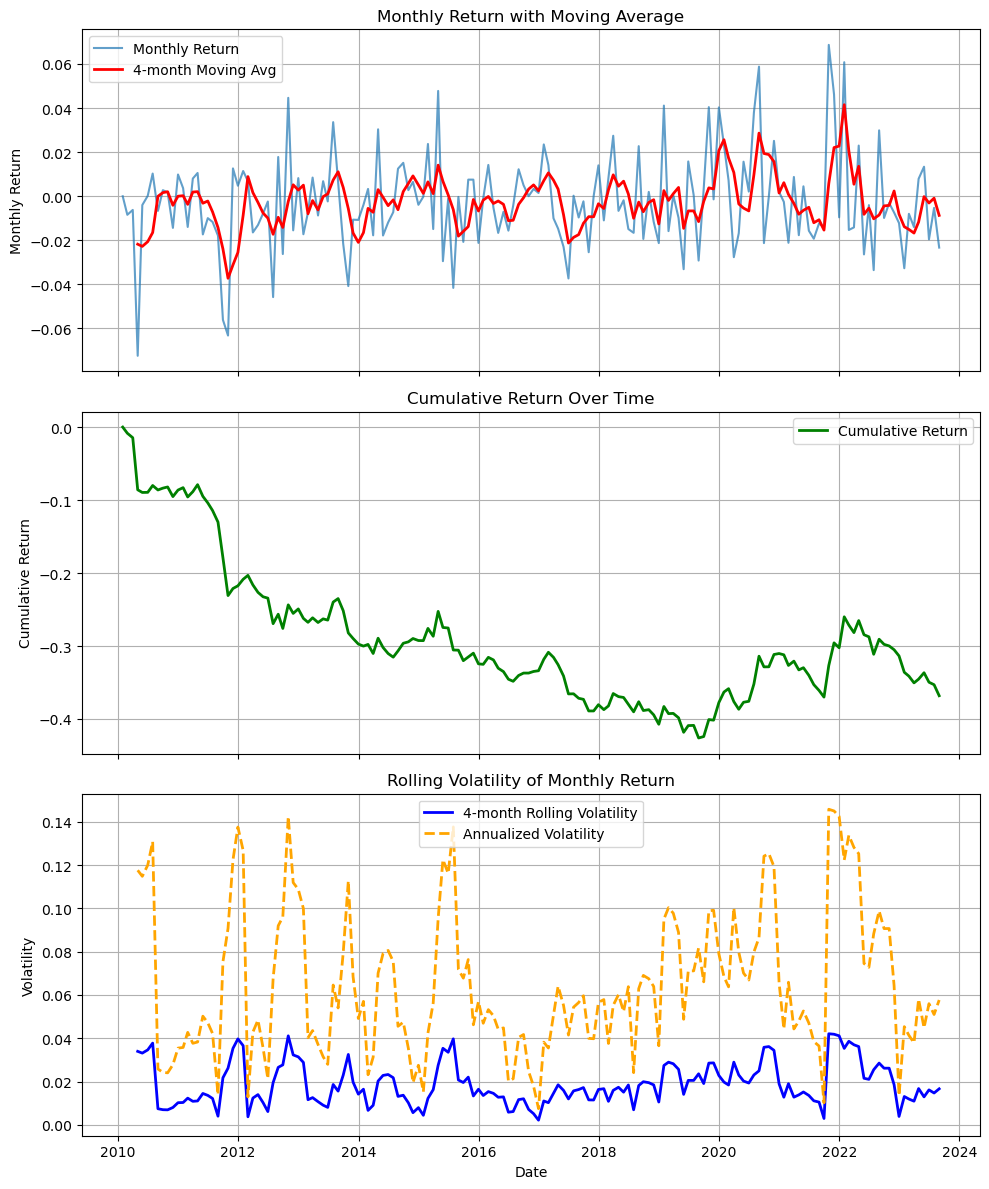

,count,mean,std,min,25%,50%,75%,max
monthly_return,164.000,-0.003,0.021,-0.072,-0.015,-0.004,0.008,0.069


In [525]:
plot_monthly_pnl(realised_h_strat_returns)

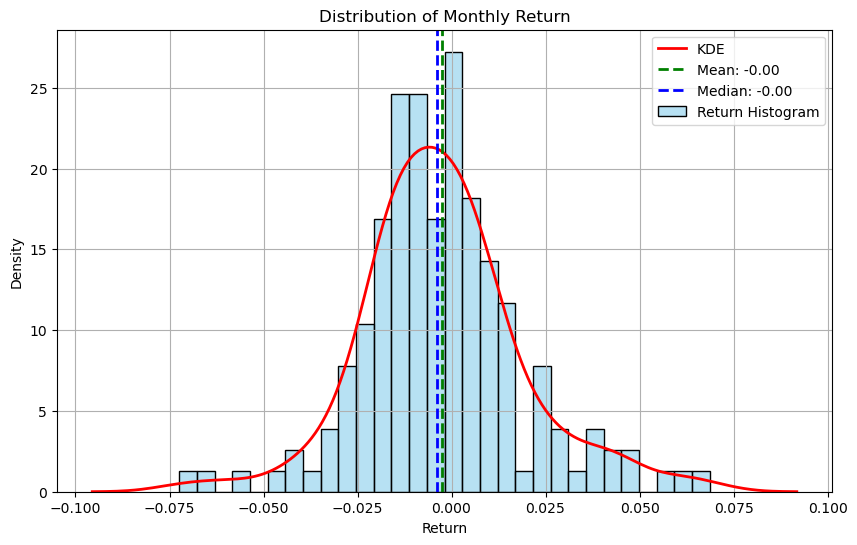

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.06,0.06,-0.06,-0.07,-0.03,-0.05,0.35,1.62


In [526]:
plot_pnl_distribution(realised_h_strat_returns)

### **Performance of portfolios sorted on implied roughness**

### Weighted portfolio of tickers based on H-values

In [527]:
implied_h_rank_df_5 = rank_H_quintiles(monthly_implied_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5,5-1
Average Monthly Return,0.0036,0.0035,0.0044,0.0049,0.0080,0.0038
Std Monthly Return,0.0179,0.0192,0.0184,0.0187,0.0319,0.0304
Median Monthly Return,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000
Cumulative Monthly Return,0.7538,0.7110,1.0078,1.1785,2.4108,0.7360
Annualized Sharpe Ratio,0.6939,0.6249,0.8317,0.9117,0.8652,0.4319
Annualized Sortino Ratio,0.9994,0.8618,1.2798,1.3522,1.8889,0.8569
Maximum Drawdown,-0.1557,-0.1598,-0.1885,-0.1673,-0.3563,-0.1948
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),45.7317,44.5122,47.5610,46.9512,47.5610,36.5854
Profit Factor,1.8326,1.7461,2.1604,2.2595,2.8125,1.7488


### Equally Weighted Portfolio

In [528]:
implied_h_rank_df_5 = rank_H_quintiles(monthly_implied_h_df, groups=5)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_5,
    monthly_prices,strategy_list_5,
    weighted_allocation=False
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5,5-1
Average Monthly Return,0.0038,0.0029,0.0044,0.0047,0.0053,0.0015
Std Monthly Return,0.0180,0.0194,0.0179,0.0181,0.0194,0.0125
Median Monthly Return,-0.0000,-0.0000,-0.0000,0.0000,0.0006,-0.0000
Cumulative Monthly Return,0.8255,0.5652,0.9861,1.1018,1.3185,0.2576
Annualized Sharpe Ratio,0.7371,0.5215,0.8398,0.8990,0.9496,0.4101
Annualized Sortino Ratio,1.1279,0.6932,1.2687,1.2727,1.3864,0.6583
Maximum Drawdown,-0.1478,-0.1929,-0.1699,-0.1794,-0.2873,-0.1074
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),42.6829,42.6829,46.3415,48.1707,50.0000,37.1951
Profit Factor,1.9050,1.6007,2.1118,2.2223,2.3570,1.4647


In [532]:
implied_h_rank_df_10 = rank_H_quintiles(monthly_implied_h_df, groups=10)
comparison_df = run_various_long_short_positions(
    implied_h_rank_df_10,
    monthly_prices,strategy_list_10,
    weighted_allocation=True
)

# Inspect results
comparison_df.style.format("{:.4f}")

,1 Smooth,2,3,4,5,6,7,8,9,10,10-1
Average Monthly Return,0.0042,0.0027,0.0029,0.0036,0.0045,0.0044,0.0050,0.0057,0.0042,0.0090,0.0045
Std Monthly Return,0.0209,0.0226,0.0211,0.0199,0.0194,0.0204,0.0210,0.0207,0.0214,0.0405,0.0421
Median Monthly Return,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000,-0.0000
Cumulative Monthly Return,0.9353,0.4873,0.5505,0.7579,1.0113,0.9882,1.1754,1.4370,0.9023,2.8949,0.8332
Annualized Sharpe Ratio,0.7050,0.4107,0.4753,0.6331,0.7966,0.7477,0.8190,0.9450,0.6730,0.7725,0.3699
Annualized Sortino Ratio,1.0682,0.5528,0.6701,0.8945,1.1170,1.2191,1.1797,1.5104,1.0545,2.0105,0.6579
Maximum Drawdown,-0.1520,-0.2231,-0.2060,-0.1127,-0.1511,-0.1880,-0.2216,-0.1995,-0.3129,-0.3806,-0.3305
Number of Periods (Months),164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000,164.0000
Win Ratio (%),43.2927,42.0732,42.0732,42.6829,46.3415,42.0732,46.3415,45.1220,42.0732,45.1220,36.5854
Profit Factor,1.8802,1.4471,1.5028,1.7613,2.0238,2.0094,2.0070,2.3803,1.8254,2.8642,1.6681


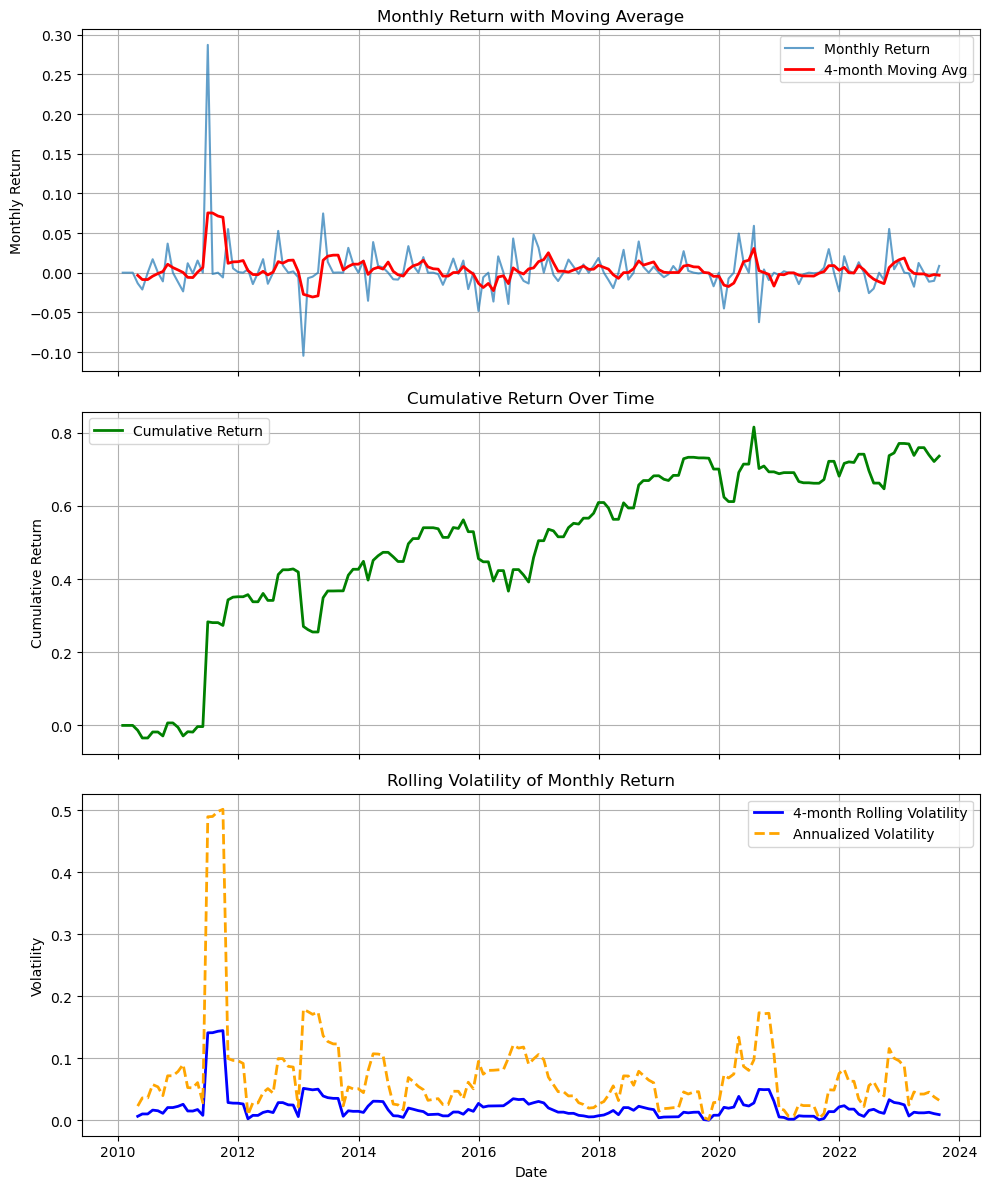

,count,mean,std,min,25%,50%,75%,max
monthly_return,164.000,0.004,0.030,-0.105,-0.004,-0.000,0.009,0.287


In [530]:
plot_monthly_pnl(implied_h_strat_returns)

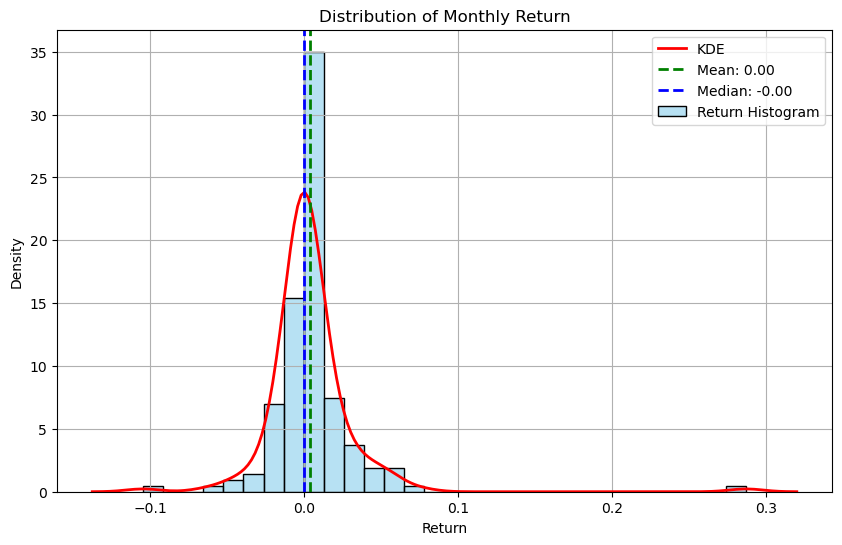

,1% Quantile,99% Quantile,1% VaR,1% ES,5% VaR,5% ES,Skewness,Kurtosis
Value,-0.05,0.06,-0.05,-0.08,-0.02,-0.05,4.80,45.44


In [531]:
plot_pnl_distribution(implied_h_strat_returns)